In [182]:
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, r2_score

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os

In [183]:
train = pd.read_csv('dataset/train.csv')
test= pd.read_csv('dataset/test.csv')
wind = 'windmill_generated_power(kW/h)'
train.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


In [184]:
train.dtypes

tracking_id                        object
datetime                           object
wind_speed(m/s)                   float64
atmospheric_temperature(°C)       float64
shaft_temperature(°C)             float64
blades_angle(°)                   float64
gearbox_temperature(°C)           float64
engine_temperature(°C)            float64
motor_torque(N-m)                 float64
generator_temperature(°C)         float64
atmospheric_pressure(Pascal)      float64
area_temperature(°C)              float64
windmill_body_temperature(°C)     float64
wind_direction(°)                 float64
resistance(ohm)                   float64
rotor_torque(N-m)                 float64
turbine_status                     object
cloud_level                        object
blade_length(m)                   float64
blade_breadth(m)                  float64
windmill_height(m)                float64
windmill_generated_power(kW/h)    float64
dtype: object

# Deal with NaN Values:

In [185]:
train.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64

### Remove rows with Null Targets

In [186]:
train = train[~train[wind].isnull()]
train.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    271
atmospheric_temperature(°C)       3422
shaft_temperature(°C)                2
blades_angle(°)                    212
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2690
area_temperature(°C)                 0
windmill_body_temperature(°C)     2352
wind_direction(°)                 5058
resistance(ohm)                      1
rotor_torque(N-m)                  567
turbine_status                    1747
cloud_level                        272
blade_length(m)                   5057
blade_breadth(m)                     0
windmill_height(m)                 538
windmill_generated_power(kW/h)       0
dtype: int64

## Split before filling

In [187]:
from sklearn.model_selection import train_test_split
X = train.drop([wind, 'tracking_id', 'datetime'], axis=1)
y = train[wind]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape

((22394, 19), (5599, 19))

### Categorical Features

In [188]:
# Function to impute most occured category and add importance vairable
def impute_categorical(DataFrame,ColName):
    #1. add new column and replace if category is null then 1 else 0
    DataFrame[ColName+"_Imputed"] =   np.where(DataFrame[ColName].isnull(),1,0)
    
    # 2. Take most occured category in that vairable (.mode())
    Mode_Category = DataFrame[ColName].mode()[0]
    
    ## 2.1 Replace NAN values with most occured category in actual vairable
    DataFrame[ColName].fillna(Mode_Category,inplace=True)

In [189]:
splited = [X_train, X_test]
for s in splited:
    for c in ['turbine_status','cloud_level']:
        impute_categorical(s, c)
    
# train[['turbine_status','turbine_status_Imputed','cloud_level','cloud_level_Imputed']].head(10)

### Numerical

In [190]:
X_train.columns

Index(['wind_speed(m/s)', 'atmospheric_temperature(°C)',
       'shaft_temperature(°C)', 'blades_angle(°)', 'gearbox_temperature(°C)',
       'engine_temperature(°C)', 'motor_torque(N-m)',
       'generator_temperature(°C)', 'atmospheric_pressure(Pascal)',
       'area_temperature(°C)', 'windmill_body_temperature(°C)',
       'wind_direction(°)', 'resistance(ohm)', 'rotor_torque(N-m)',
       'turbine_status', 'cloud_level', 'blade_length(m)', 'blade_breadth(m)',
       'windmill_height(m)', 'turbine_status_Imputed', 'cloud_level_Imputed'],
      dtype='object')

In [191]:
import datawig

def impute_any(output_column):
    df_train, df_test = datawig.utils.random_split(train)

    #Initialize a SimpleImputer model
    imputer = datawig.SimpleImputer(
        input_columns=['tracking_id', 'datetime', 'wind_speed(m/s)', 'shaft_temperature(°C)', 'blades_angle(°)',\
                       'gearbox_temperature(°C)', 'engine_temperature(°C)', 'motor_torque(N-m)', 'generator_temperature(°C)',\
                       'area_temperature(°C)', 'resistance(ohm)', 'rotor_torque(N-m)', 'turbine_status', 'cloud_level',\
                       'blade_length(m)', 'windmill_height(m)'], # column(s) containing information about the column we want to impute
        output_column= output_column, # the column we'd like to impute values for
        output_path = 'imputer_model' # stores model data and metrics
        )

    #Fit an imputer model on the train data
    imputer.fit(train_df=df_train, num_epochs=50)

    #Impute missing values and return original dataframe with predictions
    imputed = imputer.predict(df_test)
    return imputed
# w = impute_any('wind_speed(m/s)')

In [192]:
for s in splited:
    for i in s.columns:
        if s[i].isnull().sum()>0:
            mean = s[i].mean()
            s[i].replace(np.nan, mean, inplace=True)

In [193]:
X_train.shape

(22394, 21)

In [194]:
X_test.isnull().sum()

wind_speed(m/s)                  0
atmospheric_temperature(°C)      0
shaft_temperature(°C)            0
blades_angle(°)                  0
gearbox_temperature(°C)          0
engine_temperature(°C)           0
motor_torque(N-m)                0
generator_temperature(°C)        0
atmospheric_pressure(Pascal)     0
area_temperature(°C)             0
windmill_body_temperature(°C)    0
wind_direction(°)                0
resistance(ohm)                  0
rotor_torque(N-m)                0
turbine_status                   0
cloud_level                      0
blade_length(m)                  0
blade_breadth(m)                 0
windmill_height(m)               0
turbine_status_Imputed           0
cloud_level_Imputed              0
dtype: int64

In [195]:
X_train.shape, X_test.shape

((22394, 21), (5599, 21))

## Merge and keep for later use

In [196]:
train2 = pd.concat([X_train, X_test], axis = 0, ignore_index=True)
targ = pd.concat([y_train, y_test], axis = 0, ignore_index=True)
train3 = pd.concat([train2, targ], axis = 1)
# for i in range(len(train3.columns) - 1):
#     train3.rename(columns = {train3.columns[i] : train3.columns[i][0]}, inplace = True)
train3

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed,windmill_generated_power(kW/h)
0,-32.329330,26.986519,45.418365,-0.332990,43.050239,44.273523,2082.795561,76.986207,17144.779919,41.746512,43.066814,306.285040,1735.500871,34.298018,BD,Low,3.539365,0.301748,25.908725,0,0,5.033789
1,16.206770,8.396372,45.767251,-1.000410,43.653480,42.550926,781.255329,39.127358,112713.546224,27.252508,41.407374,264.988175,1234.838617,13.233969,BBB,Medium,3.929870,0.444566,25.296733,0,0,5.408458
2,93.751077,20.720326,43.992917,-1.010484,46.421361,45.656290,2178.267019,75.644249,17583.187972,37.048393,43.126185,95.767214,1758.153894,40.277421,ABC,Medium,2.278921,0.444415,40.414834,0,0,5.565930
3,94.201719,20.923178,44.987272,1.153402,46.496238,42.568750,2819.473791,93.186910,18446.433403,40.187501,43.621891,306.285040,1979.026912,127.255443,A,Medium,3.485608,0.461937,27.073804,0,0,8.740984
4,-155.388716,-99.000000,45.446966,-0.940832,41.779268,45.056795,2268.648424,74.212171,17132.349056,42.201980,42.667362,306.285040,1749.337107,35.511249,AC,Low,7.049846,0.478422,24.144998,0,0,5.500563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27988,94.733036,25.181578,76.841662,4.853451,46.188944,47.306356,2874.296970,89.687501,17678.727287,40.769173,44.206339,308.469156,1945.254959,44.011342,ABC,Low,5.481978,0.381576,24.030120,0,0,9.286689
27989,94.004107,-99.000000,45.643256,1.301626,41.012577,42.855489,2055.054278,72.260103,16651.723513,36.719047,43.404518,308.469156,1689.200688,34.704324,D,Medium,7.018900,0.473595,24.952206,0,0,3.681625
27990,13.797909,8.030946,60.883627,-9.739161,39.117791,44.972765,760.271103,39.250381,115649.083915,24.036042,19.976057,514.523726,1199.169323,13.254101,BD,Medium,2.138599,0.332841,25.783265,0,0,4.370886
27991,-34.998751,63.022986,43.276125,84.108246,107.081319,42.839361,1001.727673,67.833662,16774.570847,31.575974,-99.000000,179.945377,1664.028539,20.000000,AC,Extremely Low,2.127258,0.282598,24.670934,0,0,1.687779


## Distribution

In [197]:
# sns.set_style("white")
# sns.set_color_codes(palette='deep')
# f, ax = plt.subplots(figsize=(8, 7))
# #Check the new distribution 
# sns.distplot(train[wind], color="b");
# ax.xaxis.grid(False)
# ax.set(ylabel="Frequency")
# ax.set(xlabel=wind)
# ax.set(title=f"{wind} distribution")
# sns.despine(trim=True, left=True)
# plt.show()

In [198]:
# # log(1+x) transform
# train[wind] = np.log1p(train[wind])

# sns.set_style("white")
# sns.set_color_codes(palette='deep')
# f, ax = plt.subplots(figsize=(8, 7))
# #Check the new distribution 
# sns.distplot(train[wind] , fit=norm, color="b");

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train[wind])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# #Now plot the distribution
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# ax.xaxis.grid(False)
# ax.set(ylabel="Frequency")
# ax.set(xlabel=wind)
# ax.set(title=f"{wind} distribution")
# sns.despine(trim=True, left=True)

# plt.show()

In [199]:
y_train

15611     5.033789
27743     5.408458
15203     5.565930
21578     8.740984
20620     5.500563
           ...    
13210     8.626782
19784    11.251304
9910     12.843119
10869     2.751944
2749      8.384875
Name: windmill_generated_power(kW/h), Length: 22394, dtype: float64

## Outliers

In [200]:
# def cap_data(df):
#     for col in df.columns:
#         if (df[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']) and (col != wind):
#             print("capping the ",col)
#             percentiles = df[col].quantile([0.01,0.99]).values
#             df[col][df[col] <= percentiles[0]] = percentiles[0]
#             df[col][df[col] >= percentiles[1]] = percentiles[1]
#         else:
#             df[col]=df[col]
#     return df

# train = cap_data(train)
# train

## Numerical Values

In [201]:
from scipy import stats

pearson_p = []
for i in X_train.columns:
    if X_train[i].dtypes!='O':
        pearson_coef, p_value = stats.pearsonr(X_train[i], y_train)
        pearson_p.append([i, pearson_coef, p_value])
pearson_p_df = pd.DataFrame(pearson_p, columns=['Numerical Features', 'Pearson Coefficient', 'p-Value'])
pearson_p_df

,Numerical Features,Pearson Coefficient,p-Value
0,wind_speed(m/s),0.062456,8.366259e-21
1,atmospheric_temperature(°C),-0.001639,8.062820e-01
2,shaft_temperature(°C),0.051687,9.977299e-15
3,blades_angle(°),-0.152100,5.433052e-116
4,gearbox_temperature(°C),0.050461,4.168573e-14
5,engine_temperature(°C),0.274715,0.000000e+00
6,motor_torque(N-m),0.504983,0.000000e+00
7,generator_temperature(°C),0.389279,0.000000e+00
8,atmospheric_pressure(Pascal),-0.012765,5.610852e-02
9,area_temperature(°C),0.387430,0.000000e+00


In [202]:
pearson_p_final = []
for i in range(17):
    if pearson_p_df.loc[i, 'p-Value'] < 0.001:
        pearson_p_final.append(pearson_p_df.loc[i, 'Numerical Features'])
pearson_p_final

['wind_speed(m/s)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'generator_temperature(°C)',
 'area_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'blade_breadth(m)']

## Categorical Variables:

<AxesSubplot:xlabel='turbine_status', ylabel='windmill_generated_power(kW/h)'>

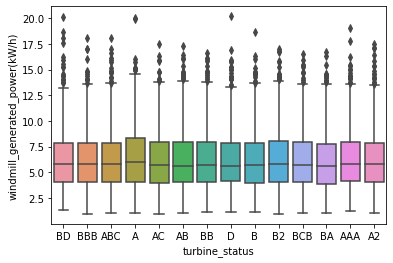

In [203]:
sns.boxplot(X_train['turbine_status'], y_train)

<AxesSubplot:xlabel='cloud_level', ylabel='windmill_generated_power(kW/h)'>

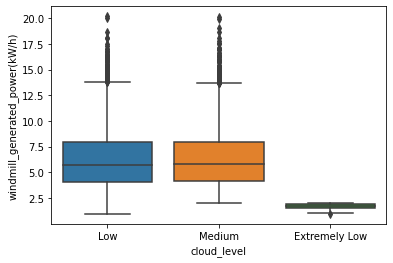

In [204]:
sns.boxplot(X_train['cloud_level'], y_train)

### Important variables we derived:
#### Numerical:
- wind_speed(m/s)
- haft_temperature(°C)
- blades_angle(°)
- gearbox_temperature(°C)
- engine_temperature(°C)
- motor_torque(N-m)
- generator_temperature(°C)
- area_temperature(°C)
- wind_direction(°)
- resistance(ohm)
- rotor_torque(N-m)
- blade_breadth(m)

#### Categorical
- cloud_level

# Encoding

In [205]:
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['turbine_status', 'cloud_level'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
15611,-32.329330,26.986519,45.418365,-0.332990,43.050239,44.273523,2082.795561,76.986207,17144.779919,41.746512,43.066814,306.285040,1735.500871,34.298018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.539365,0.301748,25.908725,0,0
27743,16.206770,8.396372,45.767251,-1.000410,43.653480,42.550926,781.255329,39.127358,112713.546224,27.252508,41.407374,264.988175,1234.838617,13.233969,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.929870,0.444566,25.296733,0,0
15203,93.751077,20.720326,43.992917,-1.010484,46.421361,45.656290,2178.267019,75.644249,17583.187972,37.048393,43.126185,95.767214,1758.153894,40.277421,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.278921,0.444415,40.414834,0,0
21578,94.201719,20.923178,44.987272,1.153402,46.496238,42.568750,2819.473791,93.186910,18446.433403,40.187501,43.621891,306.285040,1979.026912,127.255443,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.485608,0.461937,27.073804,0,0
20620,-155.388716,-99.000000,45.446966,-0.940832,41.779268,45.056795,2268.648424,74.212171,17132.349056,42.201980,42.667362,306.285040,1749.337107,35.511249,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,7.049846,0.478422,24.144998,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13210,-107.206822,14.190797,80.688395,-0.692205,137.459567,43.921804,929.826193,42.362351,118426.832893,32.415978,20.964455,232.455409,1420.695555,16.786307,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,3.385628,0.407371,26.490003,1,0
19784,94.146353,17.551073,45.146921,9.648162,48.821965,45.241926,2802.511942,92.887576,18847.194888,39.858219,43.560988,499.761898,1975.706079,47.059900,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2.357959,0.335699,27.043789,0,0
9910,41.308615,11.860592,45.693220,11.938051,49.468022,42.891585,934.817779,47.127975,141413.343409,36.924496,45.172467,516.914848,1465.555896,18.252104,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2.348490,0.445592,25.164745,1,0
10869,95.722664,26.078089,41.864851,38.798129,39.429732,42.490011,1141.501484,66.925160,16402.040513,33.423691,45.294931,106.899949,1663.606364,-53.173383,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,3.816595,0.383892,25.358264,0,0


In [206]:
X_train.shape, X_test.shape

((22394, 36), (5599, 36))

# Feature Scaling

In [207]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [208]:
X_train

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,-1.700026,0.576286,0.431208,0.027956,-0.036793,0.226713,0.032075,0.166368,-0.016271,0.841753,0.024807,0.197815,0.101435,0.095251,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260996,-0.947859,0.000000,0.0,0.0
1,-1.042975,-0.263244,0.517855,-0.074283,0.077345,-0.303091,-0.786977,-0.838100,0.944175,-0.484635,-0.046201,-0.295711,-0.792569,-0.671670,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.468745,0.444810,-0.205379,0.0,0.0
2,0.006770,0.293305,0.077194,-0.075826,0.601052,0.651997,0.092154,0.130763,-0.011865,0.411815,0.027348,-2.318018,0.141885,0.312955,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-0.409561,0.443340,4.868116,0.0,0.0
3,0.012871,0.302466,0.324145,0.255649,0.615219,-0.297609,0.495662,0.596203,-0.003190,0.699084,0.048559,0.197815,0.536285,3.479738,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.232397,0.614206,0.390990,0.0,0.0
4,-3.365926,-5.113257,0.438311,-0.065157,-0.277271,0.467616,0.149031,0.092767,-0.016396,0.883435,0.007715,0.197815,0.126141,0.139423,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.128573,0.774954,-0.591891,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22389,-2.713670,-0.001568,9.190635,-0.027071,17.826241,0.118538,-0.693482,-0.752269,1.001592,-0.012111,-0.920963,-0.684500,-0.460695,-0.542333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,1.0,0.0,0.179207,0.082108,0.195071,1.0,0.0
22390,0.012121,0.150182,0.363794,1.556922,1.055266,0.524555,0.484988,0.588262,0.000838,0.668950,0.045953,2.509996,0.530355,0.559898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-0.367513,-0.616786,0.380917,0.0,0.0
22391,-0.703163,-0.106800,0.499470,1.907699,1.177505,-0.198317,-0.690341,-0.625828,1.232601,0.400477,0.114909,2.714986,-0.380590,-0.488965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,1.0,0.0,-0.372550,0.454820,-0.249673,1.0,0.0
22392,0.033460,0.535261,-0.451318,6.022269,-0.721823,-0.321826,-0.560276,-0.100571,-0.023735,0.080108,0.120149,-2.184974,-0.026943,-3.089496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.408482,-0.146838,-0.184730,0.0,0.0


In [209]:
# necessary functions
from sklearn.decomposition import PCA
labels = np.reshape(train[wind].to_numpy(), (train.shape[0],1))

def pca_analysis(df, n_components):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(df.iloc[:, :-1].values)

    pca_concatenate = np.concatenate([pca_result, labels], axis=1)
    return pca_concatenate
def make_dataframe(array, n_features):
    col = []
    for i in range(1, n_features+1):
        col.append(f'pc{i}')
    col.append(wind)
    return pd.DataFrame(array, columns = col)

from sklearn.manifold import TSNE
def tsne_analysis(df, n_components):
    tsne = TSNE(n_components=n_components)
    tsne_result = tsne.fit_transform(df.iloc[:, :-1].values)

    tsne_concatenate = np.concatenate([tsne_result, labels], axis=1)
    return tsne_concatenate
def tsne_dataframe(array, n_features):
    col = []
    for i in range(1, n_features+1):
        col.append(f'tsne{i}')
    col.append(wind)
    return pd.DataFrame(array, columns = col)

# def get_xy(df):
#     if df.shape==37:
#         X = df.drop(wind, axis=1)
#     else:
#         X = df
#     y = train[wind].copy()
#     return X, y
def get_xy(df):
    X = df.drop(wind, axis=1)
    y = train[wind].copy()
    return X, y

# XGB

In [210]:
from sklearn.model_selection import ShuffleSplit, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.metrics import accuracy_score, r2_score
import xgboost as xgb
xgb =  xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5,
                       learning_rate = 0.03 , max_depth = 8, n_estimators = 500)

In [211]:
# fit the model
xgb.fit(X_train, y_train)

# Predict the Test set results
y_pred = xgb.predict(X_test)

In [212]:
from sklearn.metrics import accuracy_score, r2_score

# rf.score(X_test, y_test)
score = max(0, 100 * r2_score(y_test, y_pred))
score

95.95392369000852

# Test with test.csv

In [213]:
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,NaN,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,NaN,23.886434,13.501595,NaN,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,NaN,Medium,3.286975,0.407771,20.888674
12082,WM_1630,2018-11-12 17:33:20,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,NaN,0.367823,24.793606
12083,WM_24703,2019-05-27 11:53:20,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451
12084,WM_22893,2019-05-13 21:53:20,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,NaN,A,Medium,2.247676,0.394680,24.591364


In [214]:
test.isnull().sum()

tracking_id                         0
datetime                            0
wind_speed(m/s)                   126
atmospheric_temperature(°C)      1427
shaft_temperature(°C)               1
blades_angle(°)                   106
gearbox_temperature(°C)             1
engine_temperature(°C)              5
motor_torque(N-m)                  11
generator_temperature(°C)           5
atmospheric_pressure(Pascal)     1151
area_temperature(°C)                1
windmill_body_temperature(°C)     926
wind_direction(°)                2160
resistance(ohm)                     0
rotor_torque(N-m)                 281
turbine_status                    797
cloud_level                       125
blade_length(m)                  2114
blade_breadth(m)                    0
windmill_height(m)                255
dtype: int64

In [215]:
for c in ['turbine_status','cloud_level']:
    impute_categorical(test, c)

In [216]:
for i in test.columns:
    if test[i].isnull().sum()>0:
        mean = test[i].mean()
        test[i].replace(np.nan, mean, inplace=True)
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431,0,0
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,54283.324683,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823,0,0
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677,0,0
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,54283.324683,23.886434,13.501595,308.376140,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426,0,0
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1,0
12082,WM_1630,2018-11-12 17:33:20,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,2.201328,0.367823,24.793606,0,0
12083,WM_24703,2019-05-27 11:53:20,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,0,0
12084,WM_22893,2019-05-13 21:53:20,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,26.566581,A,Medium,2.247676,0.394680,24.591364,0,0


In [217]:
# X_train_final = train.drop([wind, 'tracking_id', 'datetime'], axis=1)
X_train_final = train3.drop([wind], axis=1)
y_train_final = train3[wind]
X_test_final = test.drop(['tracking_id', 'datetime'], axis=1)


X_train_final.shape, X_test_final.shape

((27993, 21), (12086, 21))

In [218]:
X_test_final

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431,0,0
1,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,54283.324683,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823,0,0
2,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677,0,0
3,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,54283.324683,23.886434,13.501595,308.376140,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426,0,0
4,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1,0
12082,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,2.201328,0.367823,24.793606,0,0
12083,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,0,0
12084,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,26.566581,A,Medium,2.247676,0.394680,24.591364,0,0


In [219]:
X_train_final = encoder.fit_transform(X_train_final)
X_test_final = encoder.transform(X_test_final)
X_train_final

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,-32.329330,26.986519,45.418365,-0.332990,43.050239,44.273523,2082.795561,76.986207,17144.779919,41.746512,43.066814,306.285040,1735.500871,34.298018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.539365,0.301748,25.908725,0,0
1,16.206770,8.396372,45.767251,-1.000410,43.653480,42.550926,781.255329,39.127358,112713.546224,27.252508,41.407374,264.988175,1234.838617,13.233969,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.929870,0.444566,25.296733,0,0
2,93.751077,20.720326,43.992917,-1.010484,46.421361,45.656290,2178.267019,75.644249,17583.187972,37.048393,43.126185,95.767214,1758.153894,40.277421,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.278921,0.444415,40.414834,0,0
3,94.201719,20.923178,44.987272,1.153402,46.496238,42.568750,2819.473791,93.186910,18446.433403,40.187501,43.621891,306.285040,1979.026912,127.255443,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.485608,0.461937,27.073804,0,0
4,-155.388716,-99.000000,45.446966,-0.940832,41.779268,45.056795,2268.648424,74.212171,17132.349056,42.201980,42.667362,306.285040,1749.337107,35.511249,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,7.049846,0.478422,24.144998,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27988,94.733036,25.181578,76.841662,4.853451,46.188944,47.306356,2874.296970,89.687501,17678.727287,40.769173,44.206339,308.469156,1945.254959,44.011342,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.481978,0.381576,24.030120,0,0
27989,94.004107,-99.000000,45.643256,1.301626,41.012577,42.855489,2055.054278,72.260103,16651.723513,36.719047,43.404518,308.469156,1689.200688,34.704324,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,7.018900,0.473595,24.952206,0,0
27990,13.797909,8.030946,60.883627,-9.739161,39.117791,44.972765,760.271103,39.250381,115649.083915,24.036042,19.976057,514.523726,1199.169323,13.254101,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.138599,0.332841,25.783265,0,0
27991,-34.998751,63.022986,43.276125,84.108246,107.081319,42.839361,1001.727673,67.833662,16774.570847,31.575974,-99.000000,179.945377,1664.028539,20.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.127258,0.282598,24.670934,0,0


In [220]:
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

X_train_final= pd.DataFrame(X_train_final, columns=[cols])
X_test_final = pd.DataFrame(X_test_final, columns=[cols])

In [221]:
xgb.fit(X_train_final, y_train_final)

# Predict the Test set results
y_pred_final = xgb.predict(X_test_final)
y_pred_final

array([ 2.5929742,  2.3394287,  3.251606 , ...,  5.16793  ,  5.3801365,
       10.710767 ], dtype=float32)

In [222]:
y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
y_pred_final_df

,windmill_generated_power(kW/h)
0,2.592974
1,2.339429
2,3.251606
3,7.397553
4,3.606870
...,...
12081,6.692911
12082,3.341324
12083,5.167930
12084,5.380136


In [223]:
submission = pd.concat([test[['tracking_id', 'datetime']], y_pred_final_df], axis=1)
submission.isnull().sum()

tracking_id                       0
datetime                          0
windmill_generated_power(kW/h)    0
dtype: int64

In [224]:
submission.shape

(12086, 3)

In [225]:
submission.to_csv('submissions/submission_xgb_extended2.3(fillna after split).csv', index=False)

### More tests

In [226]:
imp0 = ['wind_speed(m/s)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'generator_temperature(°C)',
 'area_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'blade_breadth(m)', 'cloud_level']

imp = ['motor_torque(N-m)', 'blades_angle(°)', 'atmospheric_pressure(Pascal)', 'resistance(ohm)', 'generator_temperature(°C)', 'engine_temperature(°C)']

In [227]:
from sklearn.model_selection import train_test_split
X = train3[imp0]
y = train3[wind]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape

# Encoding
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['cloud_level'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = RobustScaler()

cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])


# fit the model
xgb.fit(X_train, y_train)

# Predict the Test set results
y_pred = xgb.predict(X_test)

score = max(0, 100 * r2_score(y_test, y_pred))
score

96.66408050701077

In [228]:
X_train_final = train3[imp0]
y_train_final = train3[wind]
X_test_final = test[imp0]

X_train_final = encoder.fit_transform(X_train_final)
X_test_final = encoder.transform(X_test_final)

X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

X_train_final= pd.DataFrame(X_train_final, columns=[cols])
X_test_final = pd.DataFrame(X_test_final, columns=[cols])

xgb.fit(X_train_final, y_train_final)

# Predict the Test set results
y_pred_final = xgb.predict(X_test_final)

y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
y_pred_final_df

submission = pd.concat([test[['tracking_id', 'datetime']], y_pred_final_df], axis=1)

submission.to_csv('submissions/submission_xgb_extended2.4(fillna after split).csv', index=False)